In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import sys
import random
import functions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from functions import *
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import r2_score
import tensorflow as tf
import os
import datetime as dt
from tqdm import tnrange, tqdm_notebook, tqdm

In [2]:
df_train,df_test=LoadandCleanData(True,1,0.0,2)

In [3]:
m=df_train['y'].mean()
std=df_train['y'].std()
df_train['y']=df_train['y'].apply(lambda x: (x-m)/std)
#minv=min(df_train['y'].values)
#maxv,minv
N=len(df_train)

In [4]:
tf.reset_default_graph()
sess = tf.Session()

In [5]:
X = tf.placeholder(tf.float32,shape=[N,480], name="X")
Y = tf.placeholder(tf.float32,shape=[N,1] ,name="Y")

w1 = tf.Variable(tf.truncated_normal([480,140], stddev=0.00001), name="weights1")
b1=tf.Variable(tf.constant(0.0,shape=[140]), name="bias1")

w2 = tf.Variable(tf.truncated_normal([140,40], stddev=0.00001), name="weights2")
b2=tf.Variable(tf.constant(0.0,shape=[40]), name="bias2")

w3 = tf.Variable(tf.truncated_normal([40,1], stddev=0.00001), name="weights3")
b3=tf.Variable(tf.constant(0.0,shape=[1]), name="bias3")


Y1= tf.nn.relu(tf.matmul(X,w1)+b1)
Y2= tf.nn.relu(tf.matmul(Y1,w2)+b2)
Y_predicted = tf.matmul(Y2,w3)+b3

step=tf.square(Y - Y_predicted,name="step")
chi2= tf.reduce_sum(step, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(chi2)
tf.summary.histogram("weights1", w1)
tf.summary.histogram("biases1", b1)
tf.summary.histogram("weights2", w2)
tf.summary.histogram("biases2", b2)
tf.summary.histogram("weights3", w3)
tf.summary.histogram("biases3", b3)

tf.summary.histogram("Y", Y_predicted)
tf.summary.scalar("chi2", chi2)
summ = tf.summary.merge_all()

In [6]:
inputdata=df_train.drop("y",axis=1).as_matrix()

In [7]:
type(inputdata),inputdata.shape

(numpy.ndarray, (4209, 480))

In [8]:
inputy=df_train['y'].as_matrix()

In [9]:
inputy

array([ 2.37714138, -0.95740619, -1.92511902, ...,  0.6743769 ,
       -1.0402178 ,  0.80293207])

In [10]:
LOGDIR="./tf/{}/".format(dt.datetime.now().strftime('%Y%m%d_%H_%M_%S'))
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

In [11]:
#with tf.Session() as sess:
# Step 7: initialize the necessary variables, in this case, w and b
sess.run(tf.global_variables_initializer())
# Step 8: train the model
for j in tqdm(range(1000)): # run 100 epochs
    sess.run(optimizer,feed_dict={X:inputdata, Y:inputy.reshape(N,1)})  
    if j%5==0:
        s = sess.run(summ, feed_dict={X:inputdata, Y:inputy.reshape(N,1)})
        writer.add_summary(s, j)  
        saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), j)


100%|██████████| 1000/1000 [02:05<00:00,  9.14it/s]


In [12]:
testdata=df_test.as_matrix()
#testdata[0].reshape(1,480)

In [13]:
Ytest=sess.run([Y_predicted],feed_dict={X: testdata})
Ytrain=sess.run([Y_predicted],feed_dict={X: inputdata})

In [14]:
#[loss1,step1,b1]=sess.run([loss,step,b], feed_dict={X:inputdata, Y:inputy.reshape(N,1)})
sess.close()

In [15]:
Ytrainv=[i[0] for i in Ytrain[0][0:]]
Ytrestv=[i[0] for i in Ytest[0][0:]]

In [16]:
type(Ytrainv)

list

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00237812,  0.05707491,
         0.078478  ,  0.03567182,  0.01783591,  0.04280618,  0.24256837,
         0.68727705,  0.56718193,  0.34601665,  0.28656361,  0.35077289,
         0.24613555,  0.24851367,  0.38049941,  0.43876338,  0.30083234,
         0.21403092,  0.13079667,  0.08680143,  0.06420927,  0.03091558,
         0.03091558,  0.02497027,  0.01902497,  0.01426873,  0.01189061,
         0.01307967,  0.0059453 ,  0.00356718,  0.00356718,  0.0059453 ,
         0.00237812,  0.00475624,  0.00237812,  0.00118906]),
 array([ -5.00000000e+00,  -4.80000000e+00,  -4.60000000e+00,
         -4.40000000e+00,  -4.20000000e+00,  -4.00000000e+00,
         -3.80000000e+00,  -3.60000000e+00,  -3.40000000e+00,
         -3.20000000e+00,  -3.00000000e+00,  -2.80000000e+00,
         -2.60000000e+00,  -2.400

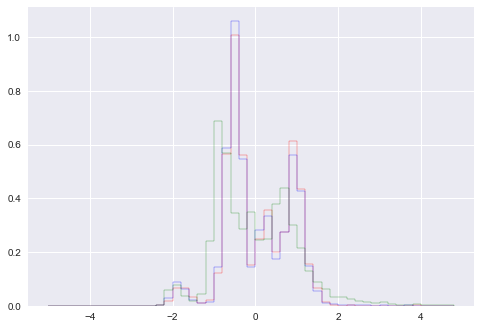

In [17]:
plt.hist(Ytrestv,bins=np.mgrid[-5:5:0.2],color="red",histtype="step",normed=True)
plt.hist(Ytrainv,bins=np.mgrid[-5:5:0.2],color='blue',histtype="step",normed=True)
plt.hist(df_train["y"].values,bins=np.mgrid[-5:5:0.2],color='green',histtype="step",normed=True)

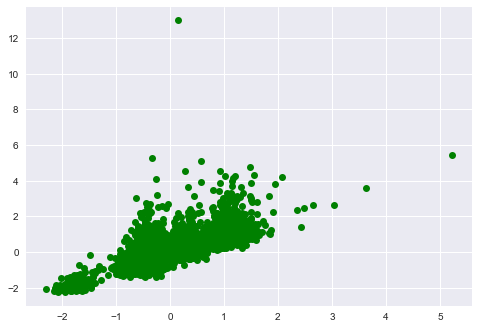

In [18]:
plt.plot(Ytrainv,df_train["y"].values,"go")

In [27]:
timestamp=dt.datetime.now().strftime('%Y%m%d_%H_%M_%S')
output = pd.DataFrame({'id': df_test2['ID'].values, 'y': Ytrestv})
output.to_csv('TF{}.csv'.format(timestamp),index=False)

In [22]:
df_test['ID'].values

0      -0.999762
1      -0.999525
2      -0.999287
3      -0.999050
4      -0.998812
5      -0.998099
6      -0.997624
7      -0.997386
8      -0.997149
9      -0.996673
10     -0.996436
11     -0.996198
12     -0.995961
13     -0.995485
14     -0.995248
15     -0.995010
16     -0.994772
17     -0.994535
18     -0.993822
19     -0.993347
20     -0.993109
21     -0.992159
22     -0.991683
23     -0.990258
24     -0.990020
25     -0.989783
26     -0.989307
27     -0.989070
28     -0.987882
29     -0.987406
          ...   
4179    0.986694
4180    0.987169
4181    0.987406
4182    0.987644
4183    0.987882
4184    0.988832
4185    0.989307
4186    0.990258
4187    0.990495
4188    0.990971
4189    0.991208
4190    0.991446
4191    0.992634
4192    0.993109
4193    0.993347
4194    0.993822
4195    0.994535
4196    0.995010
4197    0.995485
4198    0.995961
4199    0.996198
4200    0.996911
4201    0.997624
4202    0.997861
4203    0.998099
4204    0.998337
4205    0.998574
4206    0.9990

In [25]:
df_train2,df_test2=LoadandCleanData(True)

In [26]:
df_test2

,ID,X10,X12,X13,X14,X15,X16,X17,X18,X19,...,X8_4,X8_3,X8_18,X8_10,X8_23,X8_0,X8_8,X8_14,X8_22,X8_7
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,11,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
